<a href="https://colab.research.google.com/github/Massittha/Data-portfolio/blob/main/SeoulBikeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seoul Bike Rental Prediction with GridSearchCV
## Introduction

In this python notebook, I will enhance the performance of `sklearn` **DecisionTreeRegressor** by using `sklearn.model_selection.GridSearchCV` to select the best combination of its 2 hyperparametres, **criterion** and **max_depth**. The model will be used to make predictions on **'Rented Bike Count'** column in **'SeoulBikeData'** from `Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository.`, available at https://doi.org/10.24432/C5F62R.



I will cover all the processes, starting from data preparation, then GridSearchCV implementation and using resulting hyperparametres to train models, and finally finishing with testing the enhanced models with unseen data.

## Data Preparation
The preparation process involves applying one-hot encoding to some features in the dataset to make it ready for fitting regressor models.

Let's first load the dataset and see all the features.  

In [1]:
## Load data
import pandas as pd
df = pd.read_csv('SeoulBikeData.csv',encoding = 'unicode-escape')

In [2]:
# see information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [3]:
#change 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-3-1daf55df213e>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [4]:
# check null values
df.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [5]:
# show top 5 rows
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Quick Data Exploration



In [6]:
df[['Rented Bike Count','Functioning Day']].groupby('Functioning Day').sum()

,Rented Bike Count
Functioning Day,
No,0
Yes,6172314


As the rows with 'Functioning Day' = 'No' suggest Non Functional hours and have 0 'Rented Bike Count', it is reasonable to drop those rows and continue with the rest of the dataset.

In [7]:
# Select only functioning days
df_func = df[df['Functioning Day'] == 'Yes']

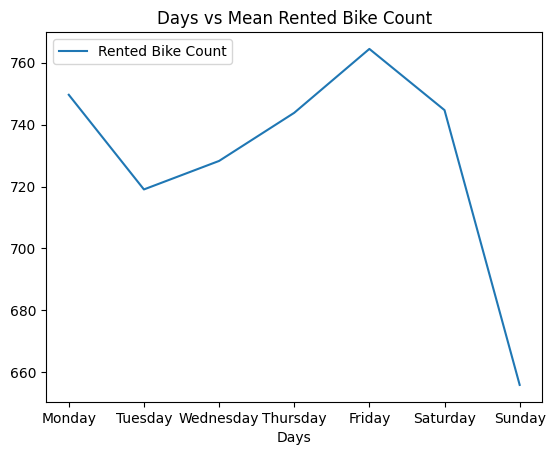

In [8]:
days = df_func['Date'].dt.day_of_week
day_name = df_func['Date'].dt.day_name()
count = df_func['Rented Bike Count']

days_count = pd.DataFrame({"Day num": days,
                           "Days": day_name,
                           "Rented Bike Count":count}
                          )
days_count = days_count.groupby(['Day num','Days']).mean().reset_index().set_index('Days')
days_count.drop('Day num',axis = 1).plot(title="Days vs Mean Rented Bike Count");


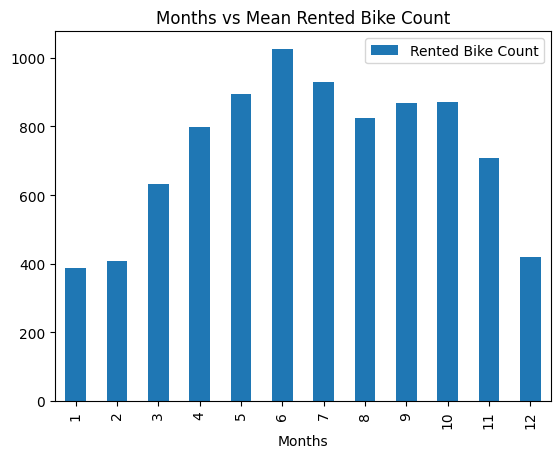

In [9]:
months = df_func['Date'].dt.month
months_count = pd.DataFrame({"Months": months,
                             "Rented Bike Count": count})

months_count.groupby('Months').mean().plot.bar(title = "Months vs Mean Rented Bike Count");


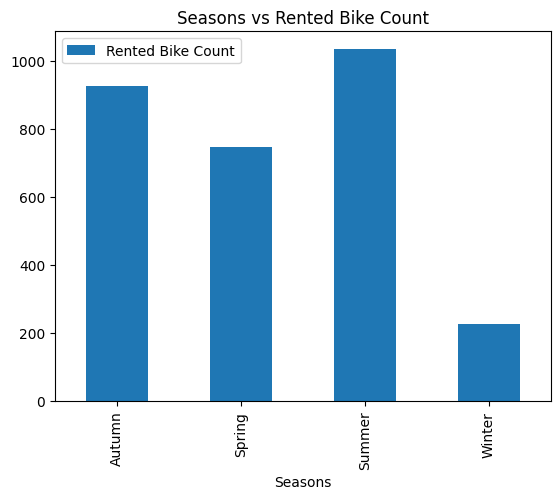

In [10]:
df_func[['Seasons','Rented Bike Count']].groupby('Seasons').mean().plot.bar(title = "Seasons vs Rented Bike Count");

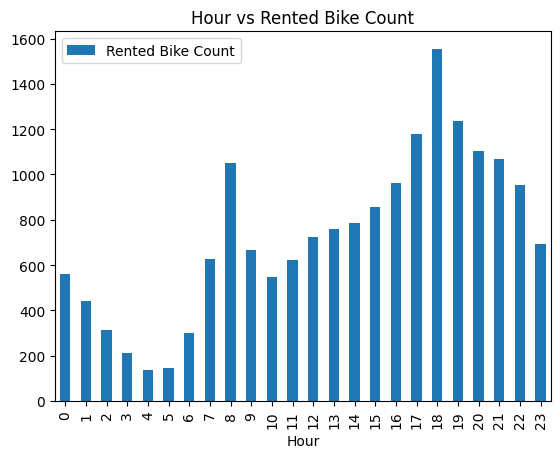

In [11]:
df_func[['Hour','Rented Bike Count']].groupby('Hour').mean().plot.bar(title = 'Hour vs Rented Bike Count');

### Apply One-hot encoding
We can see that `'Date'`, `'Seasons'`, `'Holiday'` may still not be suitable for regression model training data because of their data types (**datetime** and **object**), so they need to be transformed.

Looking at some quick plots above, it should useful for regressors to make predictions based on days of the week and months. Therefore, I extracted them from `'Date'` column and one-hot encoded them. The other three features were also one-hot encoded as shown in the code below.

Again, as we will proceed with `'Functioning Day` = `Yes`, we will not include the column in the training set.




In [12]:
days_dum = pd.get_dummies(df_func['Date'].dt.day_name())
months_dum = pd.get_dummies(df_func['Date'].dt.month_name())
seasons_dum = pd.get_dummies(df_func.Seasons)
holiday_dum = df_func['Holiday'].replace({"No Holiday":0,"Holiday":1})

In [13]:
days_full = pd.get_dummies(df['Date'].dt.day_name())
months_full = pd.get_dummies(df['Date'].dt.month_name())
seasons_full = pd.get_dummies(df.Seasons)
holiday_full = df['Holiday'].replace({"No Holiday":0,"Holiday":1})
functioning_day_full = df['Functioning Day'].replace({"No":0,"Yes":1})


In [14]:
days_dum =days_dum[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
days_dum

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
8755,0,0,0,0,0,1,0
8756,0,0,0,0,0,1,0
8757,0,0,0,0,0,1,0
8758,0,0,0,0,0,1,0


In [15]:
months_dum = months_dum[['January','February','March','April','May','June','July','August','September','October','November','December']]
months_dum

,January,February,March,April,May,June,July,August,September,October,November,December
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0,0,0,0,0,0,0,0,0,0,1,0
8756,0,0,0,0,0,0,0,0,0,0,1,0
8757,0,0,0,0,0,0,0,0,0,0,1,0
8758,0,0,0,0,0,0,0,0,0,0,1,0


In [16]:
seasons_dum

,Autumn,Spring,Summer,Winter
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
8755,1,0,0,0
8756,1,0,0,0
8757,1,0,0,0
8758,1,0,0,0


In [17]:
holiday_dum

0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: Holiday, Length: 8465, dtype: int64

Now that we have one-hot encoded columns, we can create a new dataset for model training.

In [18]:
X = pd.concat([days_dum,months_dum,df_func.iloc[:,2:11],seasons_dum,holiday_dum],axis = 1)
Y = df_func['Rented Bike Count']


In [19]:
# recheck columns of X
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sunday                     8465 non-null   uint8  
 1   Monday                     8465 non-null   uint8  
 2   Tuesday                    8465 non-null   uint8  
 3   Wednesday                  8465 non-null   uint8  
 4   Thursday                   8465 non-null   uint8  
 5   Friday                     8465 non-null   uint8  
 6   Saturday                   8465 non-null   uint8  
 7   January                    8465 non-null   uint8  
 8   February                   8465 non-null   uint8  
 9   March                      8465 non-null   uint8  
 10  April                      8465 non-null   uint8  
 11  May                        8465 non-null   uint8  
 12  June                       8465 non-null   uint8  
 13  July                       8465 non-null   uint8

## GridSearchCV

In this section, I will use GridSearchCV to select the best combination of `criterion` and `max_depth` for `DecisionTreeRegressor`, using `r2_score` as the metric.

### Import modules

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Split data, test size = 0.2

In [21]:
X_train , X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

### Implement GridSearchCV
Use GridSearchCV to perform KFold Cross Validation (n_split = 5) to iterate through `max_depth` (`depths`) and criterions (`params`), and refit the model with the best combination that obtains the highest r2_score.

In [22]:
kF = KFold(n_splits=5,shuffle = True,random_state = 42)
dtr = DecisionTreeRegressor(random_state = 42)

depths = [d for d in range(1,21)]

params = {
    'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
    'max_depth': depths,
}

## GridSearchCV
GS = GridSearchCV(estimator = dtr,param_grid = params, scoring = ['r2'], refit = 'r2', cv= kF ,verbose = 4)

GS.fit(X_train,Y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END criterion=squared_error, max_depth=1; r2: (test=0.266) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=1; r2: (test=0.243) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=1; r2: (test=0.270) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=1; r2: (test=0.277) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=1; r2: (test=0.275) total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=2; r2: (test=0.473) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; r2: (test=0.436) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; r2: (test=0.483) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; r2: (test=0.502) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; r2: (test=0.501) total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=3; r2: (test=0.615) 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             refit='r2', scoring=['r2'], verbose=4)

Show the best hyperparameters and their resulting cross validation score

In [23]:
print(f"Best estimator: {GS.best_estimator_}")
print(f"Best parameters: {GS.best_params_} ")
print(f"Best R2 score: {GS.best_score_}")

Best estimator: DecisionTreeRegressor(max_depth=10, random_state=42)
Best parameters: {'criterion': 'squared_error', 'max_depth': 10} 
Best R2 score: 0.8207193004809732


Calculate the Test score of the model with the best parameters on the unseen data

In [24]:
dtr_pred_test = GS.predict(X_test)
print(f"R2 Test: {r2_score(Y_test,dtr_pred_test)}")

R2 Test: 0.8121524423480575
